In [3]:
%matplotlib inline
 
import matplotlib.pyplot as plt
from clawpack import riemann
from clawpack import pyclaw
import numpy as np

def CharacteristicDepth(K,q,i):
    """" 
    provides the normal and critical depths associated with slope i 
    and Strickler coefficient K for the inflow rate q 
    """
    import numpy as np
    g = 9.81
    hn = (q / K / np.sqrt(i)) ** (3/5)
    hc = (q ** 2 / g) ** (1 / 3)
    return hn, hc

def hydrograph(t,t_up,q_peak):
    """
    The boundary value at the left border x = 0. Here g(t) = triangular hydrograph 
    """
    if 0 < t<= t_up: 
        q = (t/t_up) * q_peak
    elif t_up <t <= 2 * t_up:
        q = ((2*t_up-t)/t_up)*q_peak 
    else:
        q = 0
    return q

def inlet_bc(state,dim,t,qbc,auxbc,num_ghost):
    """
    inlet boundary condition
    """
    t_up   = state.problem_data['characteristic_time']
    q_p    = state.problem_data['peak_discharge']
    qIn    = state.problem_data['flow_rate']
    i      = state.problem_data["slope"]
    K      = state.problem_data["Strickler"]
    qIn    = state.problem_data["flow_rate"]
    hn, hc = CharacteristicDepth(K,qIn+hydrograph(t,t_up,q_p),i)
    qbc[0, :num_ghost] = hn
     
def initialize(state):
    """
    The initial value.  
    """    
    i   = state.problem_data["slope"]
    K   = state.problem_data["Strickler"]
    qIn = state.problem_data["flow_rate"]
    hn, hc = CharacteristicDepth(K,qIn,i)
    state.q[0,:] = hn

def Solveur(q_l,q_r,aux_l,aux_r,problem_data):
    r"""
    1d solver with flux f = a u^n with n>=1
    """
    num_eqn = 1
    num_waves = 1
    num_rp = q_l.shape[1]

    # Return values
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s    = np.empty( (num_waves, num_rp) )
    amdq = np.empty( (num_eqn, num_rp) )
    apdq = np.empty( (num_eqn, num_rp) )

    # Wave
    delta = np.empty(np.shape(q_l))
    delta = q_r - q_l
    wave[0,0,:] = delta
    
    # Parameters
    n   = problem_data['n']
    a   = problem_data['a']
 
    # Compute the shock speed
    if n>1:
        for i in range(num_rp):
            if q_r[0,i] != q_l[0,i]:
                s[0,i] =   a * (q_r[0,i]**n - q_l[0,i]**n)/(q_r[0,i]  - q_l[0,i])
            else:
                s[0,i] = 0
    else:
        s[0,:] = a * np.ones(num_rp)
    
    # Compute the left going and right going fluctuations
    s_index = np.zeros((2,num_rp))
    s_index[0,:] = s[0,:]
    amdq[0,:] = np.min(s_index,axis=0) * wave[0,0,:]
    apdq[0,:] = np.max(s_index,axis=0) * wave[0,0,:]
        
    # Compute entropy fix
    if problem_data['efix']:
        transonic = (q_l[0,:] < 0.0) * (q_r[0,:] > 0.0)
        amdq[0,transonic] = -a * q_l[0,transonic]**n
        apdq[0,transonic] =  a * q_r[0,transonic]**n

    return wave, s, amdq, apdq

def setup(L,mx,tf,nbs,K,n,q0,qp,tc,slope):
    
    solver    = pyclaw.ClawSolver1D()
    solver.rp = Solveur
    solver.num_waves = 1
    solver.num_eqn   = 1
    solver.kernel_language = 'Python'
    solver.limiters        = pyclaw.limiters.tvd.superbee
    solver.bc_lower[0]     = pyclaw.BC.custom
    solver.user_bc_lower   = inlet_bc
    solver.bc_upper[0]     = pyclaw.BC.extrap
    solver.order           = 2 #1: Godunov, 2: Lax-Wendroff-LeVeque
    
    x       = pyclaw.Dimension(0, L, mx, name='x')
    domain  = pyclaw.Domain(x)
    num_eqn = 1
    
    state = pyclaw.State(domain, num_eqn)
    
    state.problem_data['a']         = K*np.sqrt(slope)
    state.problem_data['Strickler'] = K
    state.problem_data['n']         = n
    state.problem_data['efix']      = True
    state.problem_data['dx']        = L/mx
    state.problem_data['characteristic_time'] = tc
    state.problem_data['peak_discharge']      = qp
    state.problem_data['flow_rate']           = q0
    state.problem_data['slope']               = slope
    
    xc = domain.grid.x.centers
    
    initialize(state)
     
    claw = pyclaw.Controller()
    outdir        = './_output'
    output_style  = 1
    claw.solution = pyclaw.Solution(state, domain)
    claw.solver   = solver
    claw.outdir   = outdir
    claw.output_style = output_style
    
    claw.tfinal           = tf
    claw.num_output_times = nbs
    claw.keep_copy = True
    claw.verbosity = 0
 
    return claw

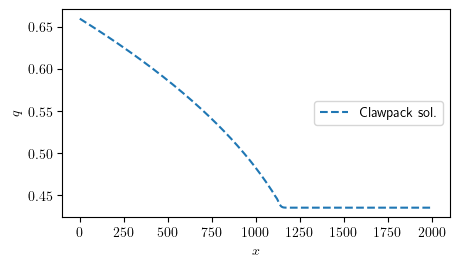

In [4]:
L = 2000 ; mx = 1000 ; tf = 1800 ; nbs = 60 ;  K = 40 ; n=5/3; q0=1; qp =2; tc=600
S=0.01; 
    
claw = setup(L,mx,tf,nbs,K,n,q0,qp,tc,S)
claw.run()

plt.rcParams['text.usetex'] = True
index = 10
frame = claw.frames[index]
dt = claw.tfinal/claw.num_output_times
t  = dt*index
x  = frame.state.grid.c_centers
x  = x[0]

x_true = np.linspace(0,L,mx)
#q_true = qsol(x_true,t,a)

fig, ax = plt.subplots(figsize=(5, 2.7))
w = frame.q[0,:]
#ax.plot(x_true,q_true, '.',label='g()')
ax.plot(x, w, '--',label='Clawpack sol.')

ax.legend(loc='right')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$q$')
plt.savefig("KinematicWave.pdf")

In [5]:
 
def burgers_animation():
    import matplotlib.animation
    import numpy
    # compute the solution with the method define above:
    #claw = setup()
    #claw.keep_copy = True
    #claw.run()
    x = claw.frames[0].grid.dimensions[0].centers
    x_true = numpy.linspace(0., L , mx)
    hn, hc = CharacteristicDepth(K,q0,S)
    
    fig = plt.figure()
    axes = plt.subplot(1, 1, 1)
    plt.rcParams['text.usetex'] = True
    axes.set_xlabel(r'$x$',fontsize=14)
    axes.set_ylabel(r'$h(x, t)$',fontsize=14)
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((0, 1))
    axes.set_title(" ")
    text = axes.text(L/2, 0.8, '')
    
    def init():

        q_true = np.full_like(x_true,hn)
        computed_line, = axes.plot(x[0], claw.frames[0].q[0, :][0], 'r')
        exact_line, = axes.plot(x_true[0], q_true[0] , 'k--')
        return  (computed_line, exact_line)
    
    computed_line, exact_line = init()
    #computed_line  = init()
    
    def fplot(n):
        tt = claw.frames[n].t
        q_true = np.full_like(x_true,hn)
        computed_line.set_data([x,], [claw.frames[n].q[0, :]])
        exact_line.set_data([x_true], [q_true ])
        
        val = f'{tt:.2f}'
        text.set_text(r'$ t = {} $ s'.format(val))
        #text.set_text(rf't = {tt:.2f} s' )
        return (computed_line, exact_line)

    frames_to_plot = range(0, len(claw.frames))
    plt.close(fig)
    return matplotlib.animation.FuncAnimation(fig, fplot, frames=frames_to_plot, interval=100,
                                   blit=True, init_func=None, repeat=False)

from IPython.display import HTML 
anim = burgers_animation()
HTML(anim.to_jshtml())

In [38]:
# Export mp4
anim.save('KinematicWave_nonlinear.mp4',fps=5,writer="ffmpeg",dpi=300)
 
    

In [6]:
import os, fnmatch
 
from clawpack.pyclaw.solution import Solution
from clawpack.pyclaw import solution

    
# Finding the home directory
from os.path import expanduser
home = expanduser("~")
cwd = os.getcwd()

user_directory = cwd

dirName = '_output'  #directory in which the results lie
dirAddress = user_directory+"/"+dirName

print("Here are the output files: "+dirAddress)
files=fnmatch.filter(os.listdir(dirAddress), 'fort.q*' )
NbSim = len(files)
print("number of files: "+str(NbSim))

# Alternative to export snapshots
def ExportAnimation():
    figs = []
 
    sol=solution.Solution(1, path=dirAddress, file_format='ascii')
    frame = np.empty((NbSim,)+sol.state.q.shape)
    xsol = np.empty((NbSim, sol.state.q.shape[1]))
    hsol = np.empty((NbSim, sol.state.q.shape[1]))
    tps  = np.empty(NbSim)

    for i in range(0,NbSim):
        sol     = solution.Solution(i, path=dirAddress, file_format='ascii')
        tps[i]  = sol.t
        xsol[i] = sol.state.grid.x.centers
        hsol[i] = sol.state.q[0]

    hmin = 0.0
    hmax = 1.2
    L = max(sol.grid.x.centers)
    x0 = min(sol.grid.x.centers)
    xmoy = (L+x0)/2

 
    for i in range(0,NbSim):
        fig = plt.figure()
        axes = plt.subplot(1, 1, 1)
        plt.rcParams['text.usetex'] = True
        axes.set_xlabel(r'$x$',fontsize=14)
        axes.set_ylabel(r'$h(x, t)$',fontsize=14)
        axes.set_xlim((x0,L))
        axes.set_ylim(( hmin, hmax))
        text = axes.text(L/2, 0.9*hmax , '')
        tt = tps[i]
        val = f'{tt:.2f}'
        text.set_text(r'$ t = {} $ s'.format(val))
        axes.set_title(" ")
        text = axes.text(xmoy, 0.9*hmax , '')
        text = axes.text(xmoy, 0.9*hmax , '')
        axes.plot(xsol[i] , hsol[i] , 'r')
        figs.append(fig)
        plt.close(fig)
    return figs

from clawpack.visclaw import animation_tools
figures = ExportAnimation()
animation_tools.interact_animate_figs(figures)

Here are the output files: /home/ancey/dossier_Clawpack/ADVECTION/Nonlinear_advection/_output
number of files: 61


interactive(children=(IntSlider(value=0, description='frameno', max=60), Output()), _dom_classes=('widget-inte…

In [7]:
 # export figures for latex
newdir = 'KinematicWaveExample_Snapshots'
if not os.path.isdir(newdir): os.mkdir(user_directory+"/"+newdir)
for i in range(len(figures)):
    figures[i].savefig(user_directory+'/'+newdir+'/Frame'+str(i)+'.png', bbox_inches='tight',dpi=300)

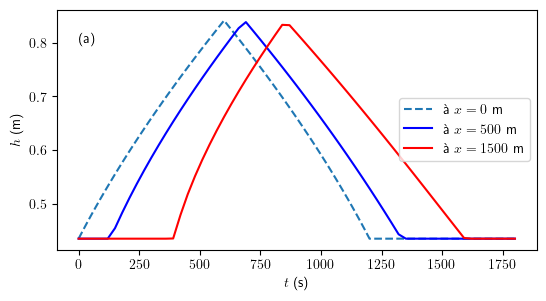

In [8]:
x_hydro1 =500
x_hydro2 =1500
dx = L/mx
k_1= int(x_hydro1/dx)
k_2= int(x_hydro2/dx)
nbs = np.size(claw.frames) 


h_1 = []
h_2 = []
tps = []

hnp, hcp = CharacteristicDepth(K,q0+qp,S)
velocity = K*hnp **(2/3)*np.sqrt(S) 
tp1 = x_hydro1/velocity
tp2 = x_hydro2/velocity

for i in range(nbs):
    h_1.append(claw.frames[i].q[0,k_1])
    h_2.append(claw.frames[i].q[0,k_2])
    tps.append(claw.frames[i].t)

 
time = np.linspace(0,max(tps),100)
hth  = list(map(lambda t: ((q0+hydrograph(t,tc,qp))/K/np.sqrt(S))**(3/5),time))

fig = plt.figure(figsize=(6,3))
left, bottom, width, heigth = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes((left ,bottom, width, heigth ))
ax.plot(time,hth ,'--', label = 'à $x = 0$ m') 
ax.plot(tps ,h_1 ,'b'  , label = 'à $x = 500$ m')
ax.plot(tps ,h_2 ,'r'  , label = 'à $x = 1500$ m')
ax.text(0,0.8,"(a)")
 
ax.set_xlabel(r'$t$ (s)')
ax.set_ylabel(r'$h$ (m)')
ax.legend(loc='right')
plt.show()

fig.savefig("ThreeHydrographsKinematicApproximation.pdf",dpi=300)

In [22]:
[imax], = np.where(np.isclose(h_1,max(h_1)))
 
print('pic en x = 500 m atteint au temps {:.1f} s'.format(tps[imax]))
print("vitesse de l'onde {:.2f} m/s".format(500/(tps[imax]-600.))) 
print("Loi de Seddon-Kleitz {:.2f} m/s".format(5/3*CharacteristicDepth(K,q0+qp,S)[0]**(2/3) *K*S**.5))

[imax], = np.where(np.isclose(h_2,max(h_2)))
 
print('pic en x = 1500 m atteint au temps {:.1f} s'.format(tps[imax]))
print("vitesse de l'onde {:.2f} m/s".format(1500/(tps[imax]-600.))) 
print("Loi de Seddon-Kleitz {:.2f} m/s".format(5/3*CharacteristicDepth(K,q0+qp,S)[0]**(2/3) *K*S**.5))

pic en x = 500 m atteint au temps 690.0 s
vitesse de l'onde 5.56 m/s
Loi de Seddon-Kleitz 5.94 m/s
pic en x = 1500 m atteint au temps 840.0 s
vitesse de l'onde 6.25 m/s
Loi de Seddon-Kleitz 5.94 m/s


In [27]:
(5.94-6.25)/5.94

-0.05218855218855212